In [27]:
import os
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score, pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
import dimod
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite

In [13]:
np.random.seed(42)

In [14]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "data"))
output_csv = os.path.join(data_dir, "antique_train_with_embeddings.csv")

def parse_embedding(text):
    return np.array(eval(text), dtype=np.float64)

train_df = pd.read_csv(output_csv, converters={"doc_embedding": parse_embedding})
doc_embeddings = np.stack(train_df["doc_embedding"].values)

In [15]:
class UMAPReducer:
    def __init__(self, n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean'):
        self.reducer = umap.UMAP(
            n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric
        )
    
    def fit_transform(self, embeddings):
        return self.reducer.fit_transform(embeddings)
    
    def plot_embeddings(self, reduced_embeddings, labels=None, save_path=None):
        fig, ax = plt.subplots(figsize=(8, 6))
        scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='Spectral', s=20, alpha=0.7)
        plt.colorbar(scatter)
        ax.set_title('UMAP Reduced Embeddings')
        if save_path:
            fig.savefig(save_path, dpi=300)
        plt.show()
        # plt.close(fig)
        
        return fig

c:\Users\karishma\OneDrive\Projects\qCLEF\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\karishma\AppData\Local\Temp\ipykernel_53752\690794951.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='Spectral', s=20, alpha=0.7)


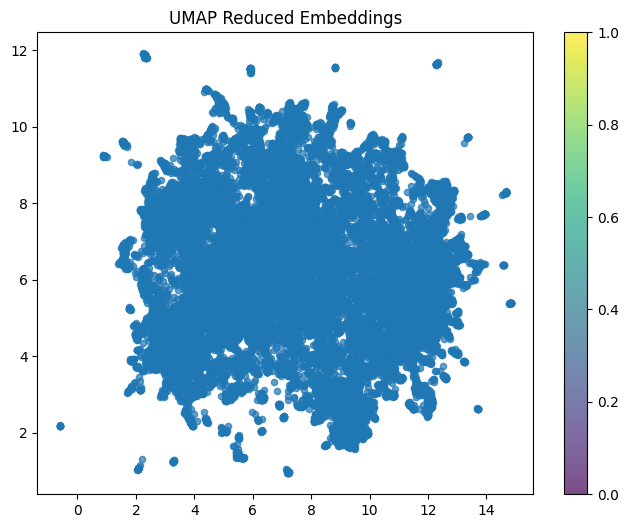

In [16]:
umap_reducer = UMAPReducer()
doc_embeddings_reduced = umap_reducer.fit_transform(doc_embeddings)
np.save(os.path.join(data_dir, "doc_embeddings_reduced.npy"), doc_embeddings_reduced)
_ = umap_reducer.plot_embeddings(doc_embeddings_reduced)

In [17]:
class ClassicalClustering:
    def __init__(self, k_range=[10, 25, 50, 75, 100], metric='euclidean'):
        self.k_range = k_range
        self.metric = metric
    
    def find_optimal_k(self, embeddings):
        best_score, best_k, best_labels, best_medoid_indices = float('inf'), None, None, None
        for k in self.k_range:
            model = KMedoids(n_clusters=k, metric=self.metric, random_state=42)
            labels = model.fit_predict(embeddings)
            score = davies_bouldin_score(embeddings, labels)
            if score < best_score:
                best_score, best_k, best_labels, best_medoid_indices = score, k, labels, model.medoid_indices_
        return best_labels, best_medoid_indices
    
    def extract_medoids(self, embeddings, medoid_indices):
        return embeddings[medoid_indices]

In [18]:
clustering = ClassicalClustering()
kmedoid_labels, medoid_indices = clustering.find_optimal_k(doc_embeddings_reduced)
medoid_embeddings = clustering.extract_medoids(doc_embeddings_reduced, medoid_indices)
np.save(os.path.join(data_dir, "medoid_embeddings.npy"), medoid_embeddings)
np.save(os.path.join(data_dir, "medoid_indices.npy"), medoid_indices)

In [19]:
print("Medoid Indices Shape:", medoid_indices.shape)
print("First 10 Medoid Indices:", medoid_indices[:10])

print("Medoid Embeddings Shape:", medoid_embeddings.shape)
print("First 5 Medoid Embeddings:\n", medoid_embeddings[:5])

Medoid Indices Shape: (10,)
First 10 Medoid Indices: [13601   215 22199 26974  8139  5934 24026 17112 10395  4207]
Medoid Embeddings Shape: (10, 2)
First 5 Medoid Embeddings:
 [[8.306715  6.217848 ]
 [5.624197  6.5435395]
 [6.591779  9.252979 ]
 [6.28956   4.56436  ]
 [9.656884  8.546417 ]]


In [24]:
len(medoid_indices)

10

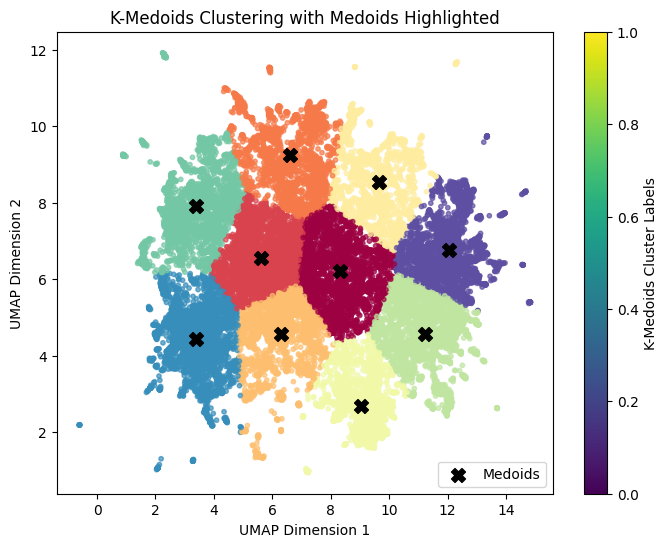

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(doc_embeddings_reduced[:, 0], doc_embeddings_reduced[:, 1], c=kmedoid_labels, cmap="Spectral", s=10, alpha=0.7)
plt.scatter(medoid_embeddings[:, 0], medoid_embeddings[:, 1], c='black', marker='X', s=100, label="Medoids")
plt.colorbar(label="K-Medoids Cluster Labels")
plt.title("K-Medoids Clustering with Medoids Highlighted")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()

In [42]:
class QuboSolver:
    def __init__(self, qubo_matrix, n_clusters, num_reads=100):
        self.qubo_matrix = qubo_matrix
        self.n_clusters = n_clusters
        self.num_reads = num_reads
    
    def run_QuboSolver(self):
        sampler = SimulatedAnnealingSampler()
        bqm = dimod.BinaryQuadraticModel.from_qubo(self.qubo_matrix)
        response = sampler.sample(bqm, num_reads=self.num_reads)
        best_sample = response.first.sample
        return self._decode_clusters(best_sample)
    
    def _decode_clusters(self, sample):
        cluster_labels = np.full(self.n_clusters, -1, dtype=int)
        cluster_indices = sorted(sample.keys(), key=lambda x: sample[x], reverse=True)[:self.n_clusters]
        for idx, var in enumerate(cluster_indices):
            cluster_labels[idx] = var
        return cluster_labels

dbi_results = []

class QuantumClustering:
    def __init__(self, k_range):
        self.k_range = k_range  

    def build_qubo_matrix(self, medoid_embeddings):
        norms = np.linalg.norm(medoid_embeddings, axis=1, keepdims=True)
        cosine_matrix = (medoid_embeddings @ medoid_embeddings.T) / (norms @ norms.T)
        np.fill_diagonal(cosine_matrix, 0)
        for idx in range(len(medoid_embeddings)):
            cosine_matrix[idx, idx] += 2  
        return cosine_matrix
    
    def solve_qubo(self, qubo_matrix, full_embeddings):
        """Runs QUBO solver for different k values, reassigns all points, and selects the best using DBI."""
        best_dbi = float("inf")
        best_k = None
        best_refined_medoid_indices = None

        for k in self.k_range:
            solver = QuboSolver(qubo_matrix, k)
            refined_medoid_indices = solver.run_QuboSolver()

            refined_medoid_embeddings = full_embeddings[refined_medoid_indices]

            final_kmedoids = KMedoids(n_clusters=k, metric='euclidean', random_state=42, init=refined_medoid_embeddings)
            final_kmedoids.fit(full_embeddings)

            final_cluster_labels = final_kmedoids.labels_
            dbi = davies_bouldin_score(full_embeddings, final_cluster_labels)
            
            dbi_results.append((k, dbi))
            print(f"k={k}, DBI={dbi}")  

            if dbi < best_dbi:
                best_dbi = dbi
                best_k = k
                best_refined_medoid_indices = refined_medoid_indices

        print(f"Selected k={best_k} with DBI={best_dbi}")
        return np.array(best_refined_medoid_indices)

In [43]:
k_range = [2, 3, 4, 5, 6, 7, 8, 9]  

quantum_clustering = QuantumClustering(k_range)
qubo_matrix = quantum_clustering.build_qubo_matrix(medoid_embeddings)
refined_medoid_indices = quantum_clustering.solve_qubo(qubo_matrix, doc_embeddings_reduced)

refined_medoid_embeddings = doc_embeddings_reduced[refined_medoid_indices]

final_kmedoids = KMedoids(n_clusters=len(refined_medoid_indices), metric='euclidean', random_state=42, init=refined_medoid_embeddings)
final_kmedoids.fit(doc_embeddings_reduced)

final_cluster_labels = final_kmedoids.labels_
np.save(os.path.join(data_dir, "final_quantum_clusters.npy"), final_cluster_labels)
np.save(os.path.join(data_dir, "refined_medoid_embeddings.npy"), refined_medoid_embeddings)
np.save(os.path.join(data_dir, "refined_medoid_indices.npy"), refined_medoid_indices)

print(f"Original medoids: {len(medoid_indices)}, Selected refined medoids: {len(refined_medoid_indices)}")

k=2, DBI=0.8950771596803756
k=3, DBI=0.9850451329706337
k=4, DBI=0.9369888529091122
k=5, DBI=0.8539425015214878
k=6, DBI=0.7840068245845974
k=7, DBI=0.8453803298390674
k=8, DBI=0.7998965415070274
k=9, DBI=0.8688206532109075
Selected k=6 with DBI=0.7840068245845974
Original medoids: 10, Selected refined medoids: 6


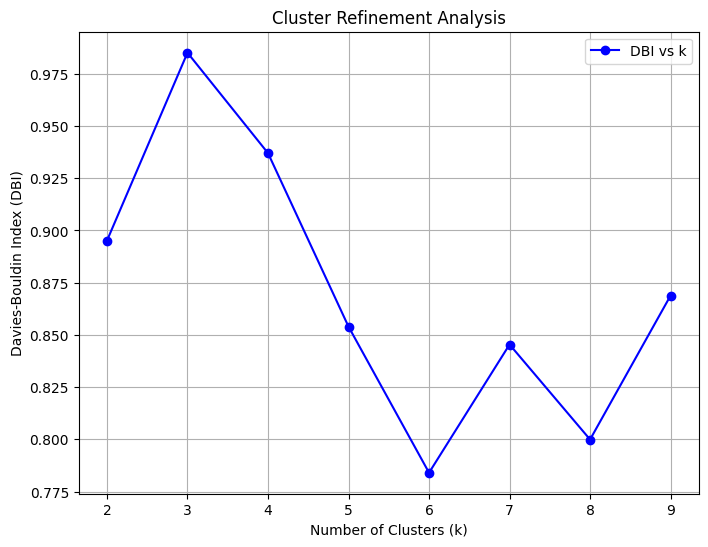

In [44]:
dbi_results = np.array(dbi_results)

def plot_dbi_results(dbi_results):
    """Generates a scatter plot of k vs DBI with a line connecting points."""
    k_values, dbi_values = dbi_results[:, 0], dbi_results[:, 1]

    plt.figure(figsize=(8, 6))
    plt.plot(k_values, dbi_values, marker='o', linestyle='-', color='b', label="DBI vs k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Davies-Bouldin Index (DBI)")
    plt.title("Cluster Refinement Analysis")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_dbi_results(dbi_results)

In [45]:
refined_medoid_indices = np.load(os.path.join(data_dir, "refined_medoid_indices.npy"))
refined_medoid_embeddings = np.load(os.path.join(data_dir, "refined_medoid_embeddings.npy"))

In [46]:
distances = pairwise_distances(doc_embeddings_reduced, refined_medoid_embeddings, metric='euclidean')
closest_medoid = np.argmin(distances, axis=1)
final_quantum_clusters = refined_medoid_indices[closest_medoid]

In [47]:
np.save(os.path.join(data_dir, "final_quantum_clusters.npy"), final_quantum_clusters)

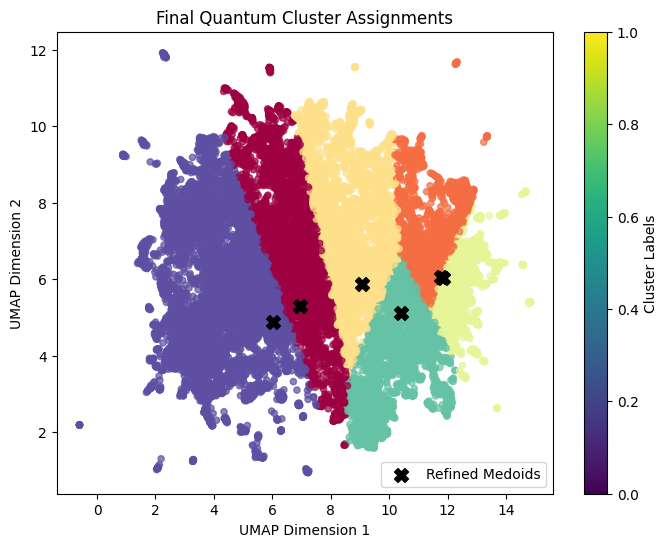

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(doc_embeddings_reduced[:, 0], doc_embeddings_reduced[:, 1], c=final_quantum_clusters, cmap='Spectral', s=20, alpha=0.7)
plt.scatter(refined_medoid_embeddings[:, 0], refined_medoid_embeddings[:, 1], c='black', marker='X', s=100, label='Refined Medoids')
plt.colorbar(label="Cluster Labels")
plt.title("Final Quantum Cluster Assignments")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()